# Self organizing maps

This is SOM but not SOM

## Sub-area connections

We will start with a network that has 3 layers. The first layer is sensors. And the network will have a difference with standard artificial neural networks. 

The difference is that every neuron $i$ in the presynaptic layer has a matrix $W_i$ instead of having only one matrix $W$ for the whole layer. These matrices, $W_i$ connect the neuron $i$ with a subset of neurons in the next layer. This subset is a group of neurons located just above the neuron $i$ within a radius $r$.

In [2]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import math

input_x = 15
output_x = 9
radius = 4
for i in range(input_x):
    k = ((output_x - radius) / input_x) * i
    print(i, k, math.floor(k))

0 0.0 0
1 0.3333333333333333 0
2 0.6666666666666666 0
3 1.0 1
4 1.3333333333333333 1
5 1.6666666666666665 1
6 2.0 2
7 2.333333333333333 2
8 2.6666666666666665 2
9 3.0 3
10 3.333333333333333 3
11 3.6666666666666665 3
12 4.0 4
13 4.333333333333333 4
14 4.666666666666666 4


In [4]:
class ColumnLayer:
    def __init__(self, input_shape, output_shape, radius, init_std=0.01):
        """
        Initialize the network.
        
        Args:
            input_shape (tuple): Shape of the input layer (height, width).
            output_shape (tuple): Shape of the output layer (height, width).
            radius (int): Radius for the connection neighborhood.
            init_std (float): Standard deviation for weight initialization.
        """
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.radius = radius
        
        # Initialize weights for each neuron in the input grid
        self.weights = []
        for i in range(input_shape[0]):
            row_weights = []
            for j in range(input_shape[1]):
                w_shape = (self.radius, self.radius)
                row_weights.append(torch.randn(w_shape) * init_std)
            self.weights.append(row_weights)

    def area_position(self, x, y):
        row_start = math.floor(((self.output_shape[0] - self.radius) / self.input_shape[0]) * x)
        row_end = row_start + self.radius
        col_start = math.floor(((self.output_shape[1] - self.radius) / self.input_shape[1]) * y)
        col_end = col_start + self.radius
        
        return (slice(row_start, row_end), slice(col_start, col_end))
    
    def forward(self, input_grid):
        """
        Perform a forward pass of the network.
        
        Args:
            input_grid (torch.Tensor): Input tensor of shape (H_in, W_in).
        
        Returns:
            torch.Tensor: Output tensor of shape (H_out, W_out).
        """
        output_grid = torch.zeros(self.output_shape)
        
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]):
                weight = self.weights[i][j]
                (x_s, y_s) = self.area_position(i, j)
                output_slice = output_grid[x_s, y_s]
                
                # Update the output slice based on the weight and input
                output_slice += input_grid[i, j] * weight
                
        return output_grid

    def update_weights(self, x, y_t, learning_rate=0.05):
        """
        Manually update weights based on provided gradients.
        
        Args:
            gradients (list of lists of torch.Tensor): Gradient for each weight matrix.
            learning_rate (float): Learning rate for weight updates.
        """
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]):
                
                w = self.weights[i][j]
                (x_s, y_s) = self.area_position(i, j)
                oja = y_t * (x - y_t * w)
                self.weights[i][j] += learning_rate * oja



We have inputs to an Artificial Neural Network like these:

In [5]:
input = torch.tensor([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1]
], dtype=torch.float)

They represent some geometric objects. In this case it's a line.

The receptive field in our ANN will be bigger than this input. Every input is randomly moved.

So next, we take the input and create K=5 displacements (moving the original tensor in receptive field by (x,y) offset).

In [6]:
K = 5
N = 15

In [7]:
def create_displaced_tensors(tensor, K, receptive_field_size=(15, 15)):
    """
    Creates K displacements of the input tensor by moving it within a larger receptive field.
    
    Parameters:
        tensor (torch.Tensor): The original input tensor of shape (5, 5).
        K (int): The number of displacements to create.
        receptive_field_size (tuple): The dimensions of the receptive field (height, width).
        
    Returns:
        batch of tensors: A tensor of K tensors with the original tensor displaced within the receptive field.
    """
    
    # Create a larger tensor filled with zeros (the receptive field)
    receptive_field_h, receptive_field_w = receptive_field_size
    displaced_tensors = torch.zeros(K, receptive_field_h, receptive_field_w, dtype=tensor.dtype)
    
    # Calculate padding size based on the receptive field dimensions
    input_h, input_w = tensor.shape
    padding_h = receptive_field_h - input_h
    padding_w = receptive_field_w - input_w
    
    for i in range(K):
        # Randomly choose top-left corner for placing the input tensor within the receptive field
        max_x_offset = padding_h
        max_y_offset = padding_w
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Place the input tensor within the receptive field at the chosen offset
        displaced_tensors[i, x_offset:x_offset + input_h, y_offset:y_offset + input_w] = tensor

    return displaced_tensors

input_saccades = create_displaced_tensors(input,
                                          K=K,
                                          receptive_field_size=(N, N))

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

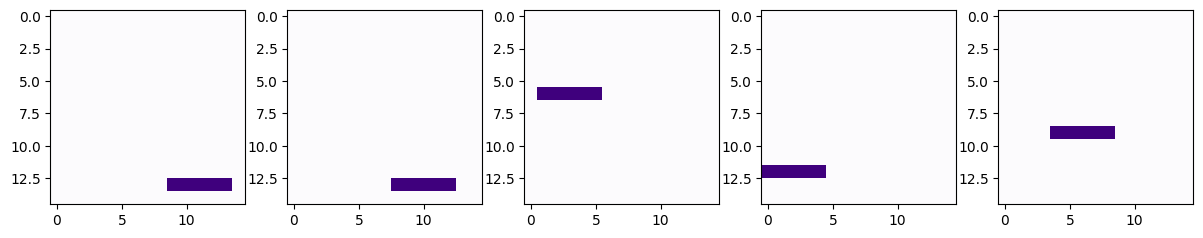

In [9]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
    axs[i].imshow(input_saccades[i].detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()


In [10]:
new_input = torch.tensor([
  [1, 1, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 1, 1, 1, 1]
], dtype=torch.float)
test_set = create_displaced_tensors(new_input,
                                    K=K,
                                    receptive_field_size=(N, N))

In [11]:
input_shape = (N, N)
output_shape = (8, 8)
radius = 4

layer = ColumnLayer(input_shape, output_shape, radius, init_std=0.01)

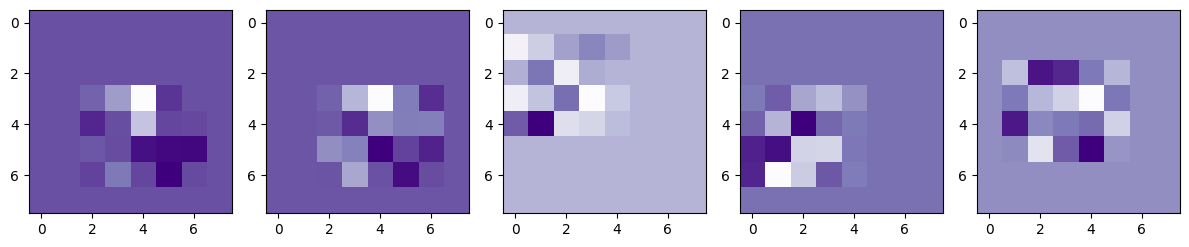

In [12]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
    x = input_saccades[i] # what is activated from sensors
    y = layer.forward(x)
    # y_t = y.unsqueeze(0).T
    # layer.update_weights(x, y_t)
    axs[i].imshow(y.detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

## Columns

In order to prepare the network to have connections in more sparse but also tangled way, we need more intricate structures that represent these connections.

First of all, there is no need to connect a neuron from one corner to absolutely opposite area on the next layer. Neurons are generally organized in columns. So higher amount of connected layers prevails over simultaneous connections to all the neurons on the next level. Which means that instead of a big matrix $W$ that covers the whole layer, we will be using smaller matrices $W_r$ that work only within a radius $r$. Although that radius covers several layers above the neuron.

And there are two approaches here. One is when the matrix is assigned to the initiating neuron. It is absolutely straight forward for the forward pass because it follows the activation potential.

One the other side, it mixes synapses from different neurons and doesn't represent the full picture of the full dendrite network of one neuron. So this is the opposite matrix that has all synapses for all dendrites.

When you know all activations from sensors then in the first case matrices will define what next neurons are activated. In the second case, matrices from all neurons should be applied because sensors don't have information about post synaptic connections.

The diff for the learning update is simpler for the second case because it applies to every matrix separately. While in the first case the update is a sum of several matrices (the number is not known). But the update must happen along the activation path and doesn't need to affect the whole neuron. Which means the first method is preferable.

## Positive weights

Set a little value in the beginning. During training values can be increased or decreased by a negative feedback.

In [13]:
class Neuron:
    def __init__(self, pos, 
                 field_height,
                 field_width,
                 column_height, 
                 column_width, 
                 n_dendrites, 
                 n_synapses):
        self.pos = pos
        self.max_pos_y = field_height
        self.max_pos_x = field_width
        self.column_height = column_height
        self.column_width = column_width
        self.n_dendrites = n_dendrites
        self.n_synapses = n_synapses
        
        n_post_neurons = column_height * (column_width * column_width)
        # n = n_post_neurons * n_dendrites * n_synapses
        
        # self.weight = torch.randn((1, n_post_neurons))
        self.weight = torch.full((1, n_post_neurons), 0.1)
        
        self.learning_rate = 0.05

    def i_to_neuron_pos(self, i):
        if self.column_width % 2 == 0:
            # no neuron on the same position above the current one
            start_pos = - (self.column_width // 2) + 1
        else:
            start_pos = - (self.column_width // 2)
        
        fix_x = 0
        fix_y = 0
        
        # if start_pos + self.pos[0] < 0:
        #     # start_pos + self.pos[0] + fix_x = 0
        #     fix_x = -(start_pos + self.pos[0])
        # elif start_pos + self.pos[0] + self.column_width >= self.max_pos_x:
        #     # start_pos + self.pos[0] + fix_x = self.max_pos_x - 1 - self.column_width
        #     fix_x = -(start_pos + self.pos[0]) + self.max_pos_x - 1 - self.column_width
            
        # if start_pos + self.pos[1] < 0:
        #     fix_y = -(start_pos + self.pos[1])
        # elif start_pos + self.pos[1] + self.column_width >= self.max_pos_y:
        #     fix_y = -(start_pos + self.pos[1]) + self.max_pos_y - 1 - self.column_width
        
        #print("fix", fix_x, fix_y)
        level = i // (self.column_width * self.column_width)
        level_i = i % (self.column_width * self.column_width)
        
        return (start_pos + self.pos[0] + fix_x + level_i % self.column_width,
                start_pos + self.pos[1] + fix_y + level_i // self.column_width,
                level)
        # if level < 1:
        #     # first level
        #     return (start_pos + self.pos[0] + i % self.column_width,
        #             start_pos + self.pos[1] + i // self.column_width,
        #             0)
        # else:
        #     # not the first level
        #     # print(i, level, "not the first level")
        #     level_i = i % (self.column_width * self.column_width)
        #     return (start_pos + self.pos[0] + level_i % self.column_width,
        #             start_pos + self.pos[1] + level_i // self.column_width,
        #             level)
    
    def forward(self, x):
        """
        x is a scalar.
        It basically indicates if this column is activated or not.
        and if it is then it works as a multiplier 
        (maybe important during summation and threshold within an activation function)
        
        The output is an array of neurons across this column
        """
        return x * self.weight

    def update_weights(self, x, y):
        oja_diff = y * (x - y * self.weight)
        self.weight += self.learning_rate * oja_diff


In [14]:
field_width = 15
field_height = 15

column_height = 3
column_width = 2

n_dendrites = 12 # some of them are in the column width but some can lie outside
n_synapses = 4 # possible duplicate connections between pre-synaptic axon and post-synaptic dendrites


In [15]:
neuron = Neuron(
    (1, 14),
    field_height=field_height,
    field_width=field_width,
    column_height=column_height,
    column_width=column_width,
    n_dendrites=n_dendrites,
    n_synapses=n_synapses
)

In [16]:
neuron.forward(42.0).shape[1]

12

In [17]:
for i in range(column_width * column_width * column_height):
    pos = neuron.i_to_neuron_pos(i)
    print(i, pos)

0 (1, 14, 0)
1 (2, 14, 0)
2 (1, 15, 0)
3 (2, 15, 0)
4 (1, 14, 1)
5 (2, 14, 1)
6 (1, 15, 1)
7 (2, 15, 1)
8 (1, 14, 2)
9 (2, 14, 2)
10 (1, 15, 2)
11 (2, 15, 2)


In [18]:

neurons = []

for x in range(field_width):
    for y in range(field_height):
        neuron = Neuron(
            (x, y),
            field_height=field_height,
            field_width=field_width,
            column_height=column_height,
            column_width=column_width,
            n_dendrites=n_dendrites,
            n_synapses=n_synapses
        )
        neurons.append(neuron)


In [19]:
x = input_saccades[0]
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0.,

In [20]:
# yy = []
# for x in range(field_width):
#     row = []
#     for y in range(field_height):
#         row.append(torch.zeros(5))
#     yy.append(row)

y_total = torch.zeros(column_height, field_width, field_height)

for n in neurons:
    xx = input_saccades[0][n.pos[0], n.pos[1]]
    y = n.forward(xx)
    for i in range(y.shape[1]):
        p = n.i_to_neuron_pos(i)
        #print(i, n.pos[0], n.pos[1], p)
        if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
            continue
        y_total[p[2], p[0], p[1]] += y[0,i]


# yy
y_total
        

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0

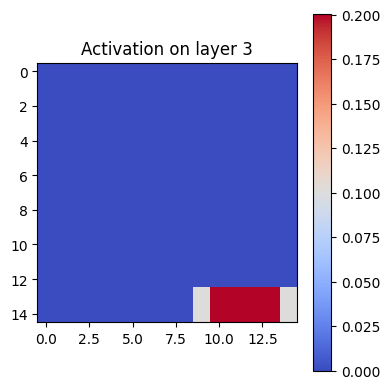

In [21]:
plt.figure(figsize=(4, 4))
x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
plt.colorbar(x_mat)
plt.title("Activation on layer 3")
plt.tight_layout()
plt.show()

In [22]:

n_column_neurons = column_width * column_width * column_height

for n in neurons:
    xx = input_saccades[0][n.pos[0], n.pos[1]]
    yy = torch.zeros(1, n_column_neurons)
    for i in range(n_column_neurons):
        p = n.i_to_neuron_pos(i)
        if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
            continue
        
        yy[0, i] = y_total[p[2], p[0], p[1]]

    n.update_weights(xx, yy)

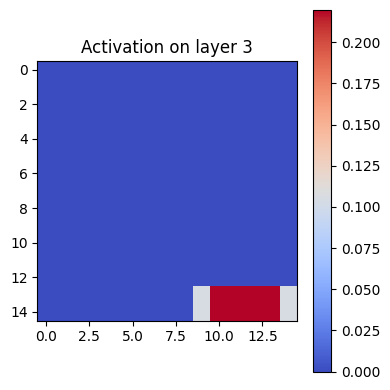

In [23]:
y_total = torch.zeros(column_height, field_width, field_height)

for n in neurons:
    xx = input_saccades[0][n.pos[0], n.pos[1]]
    y = n.forward(xx)
    for i in range(y.shape[1]):
        p = n.i_to_neuron_pos(i)
        if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
            continue
        y_total[p[2], p[0], p[1]] += y[0,i]

plt.figure(figsize=(4, 4))
x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
plt.colorbar(x_mat)
plt.title("Activation on layer 3")
plt.tight_layout()
plt.show()

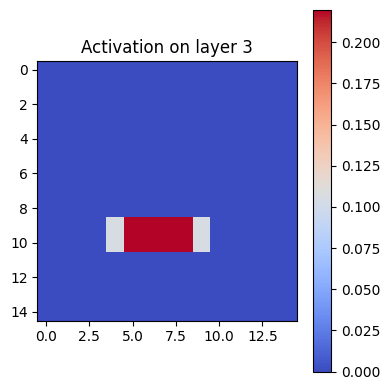

In [24]:
# create / reset the network
neurons = []

for h in range(column_height):
    neurons.append([])
    for x in range(field_width):
        for y in range(field_height):
            neuron = Neuron(
                (x, y, h),
                field_height=field_height,
                field_width=field_width,
                column_height=column_height,
                column_width=column_width,
                n_dendrites=n_dendrites,
                n_synapses=n_synapses
            )
            neurons[h].append(neuron)

# train
for k in range(K):
    input_data = [ input_saccades[k] ]
    
    for h in range(column_height):
        # forward
        y_total = torch.zeros(column_height, field_width, field_height)

        for n in neurons[h]:
            xx = input_data[h][n.pos[0], n.pos[1]]
            y = n.forward(xx)
            for i in range(y.shape[1]):
                p = n.i_to_neuron_pos(i)
                if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                    continue
                y_total[p[2], p[0], p[1]] += y[0,i]
        
        input_data.append(y_total[h])
        
        # update
        for n in neurons[h]:
            xx = input_data[h][n.pos[0], n.pos[1]]
            yy = torch.zeros(1, n_column_neurons)
            for i in range(n_column_neurons):
                p = n.i_to_neuron_pos(i)
                if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                    continue
                yy[0, i] = y_total[p[2], p[0], p[1]]

            n.update_weights(xx, yy)

# test
y_total = torch.zeros(column_height, field_width, field_height)

for n in neurons[0]:
    xx = input_data[0][n.pos[0], n.pos[1]]
    y = n.forward(xx)
    for i in range(y.shape[1]):
        p = n.i_to_neuron_pos(i)
        if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
            continue
        y_total[p[2], p[0], p[1]] += y[0,i]

plt.figure(figsize=(4, 4))
x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
plt.colorbar(x_mat)
plt.title("Activation on layer 3")
plt.tight_layout()
plt.show()


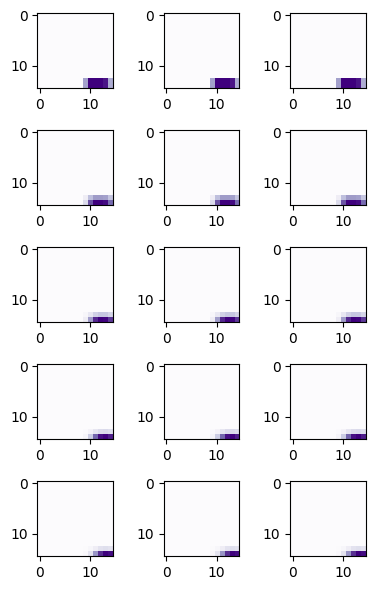

In [25]:
# test
# y_total = torch.zeros(column_height, field_width, field_height)
input_data = [ input_saccades[0] ]
states = []

y_total = torch.zeros(column_height, field_width, field_height)
levels = [0,1,2,1,0]

for l in range(len(levels)):
    y_total = torch.zeros(column_height, field_width, field_height)
    active_level = levels[l]
    for n in neurons[active_level]:
        xx = input_data[-1][n.pos[0], n.pos[1]]
        y = n.forward(xx)
        for i in range(y.shape[1]):
            p = n.i_to_neuron_pos(i)
            if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                continue
            y_total[p[2], p[0], p[1]] += y[0,i]
    next_level = levels[l+1] if l < len(levels) - 1 else levels[-1]
    input_data.append(y_total[next_level])
    states.append(y_total)

# plt.figure(figsize=(4, 4))
# x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# # x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
# plt.colorbar(x_mat)
# plt.title("Activation on layer 3")
# plt.tight_layout()
# plt.show()

fig, axs = plt.subplots(5, column_height, figsize=(4, 6))
for i in range(5):
    for j in range(column_height):
        axs[i,j].imshow(states[i][j], cmap=cm.Purples)

plt.tight_layout()
plt.show()

## Threshold

I want to research how one thing can be implemented with matrix and vector multiplication. It resembles artificial neural networks but I plan to use another features in the network about propagating the signal. It might be similar to logic gates but I don't think they lie in a matrix realm.
So the first feature is a threshold. We take vector, multiply it by a matrix and if values are lower than the threshold then the output is all zeros. This check should be another multiplication or something. Something efficient.
And in case values are accumulated enough then the result will have some non zero values where values are greater than a threshold.

It looks like a regular ANN. We multiply the input vector $\mathbf{x}$ by a matrix $\mathbf{M}$:

$
\mathbf{y} = \mathbf{M} \cdot \mathbf{x}
$

This gives us a resulting vector $\mathbf{y}$.

Then we use a threshold value $\tau$ to make a comparator-like operation using ReLU-like functions:

$
\mathbf{m} = \text{ReLU}(\mathbf{y} - \tau)
$

It outputs 1 for values $\geq 0$ and 0 for values < 0. 

We can use $\mathbf{m}$ as a binary mask to retain only activted values:

$
\mathbf{z} = \mathbf{y}\prime \odot \mathbf{m}
$

where $\odot$ is the element-wise multiplication.

During training the threshold can be lowered.

In [42]:
class NeuronWithThreshold:
    def __init__(self, pos, 
                 field_height,
                 field_width,
                 column_height, 
                 column_width, 
                 n_dendrites, 
                 n_synapses,
                 threshold=4.0):
        self.pos = pos
        self.max_pos_y = field_height
        self.max_pos_x = field_width
        self.column_height = column_height
        self.column_width = column_width
        self.n_dendrites = n_dendrites
        self.n_synapses = n_synapses
        self.threshold = threshold
        
        n_post_neurons = column_height * (column_width * column_width)
        # n = n_post_neurons * n_dendrites * n_synapses
        
        # self.weight = torch.randn((1, n_post_neurons))
        self.weight = torch.full((1, n_post_neurons), 0.1)
        self.accum_y = torch.zeros_like(self.weight)
        
        self.learning_rate = 0.05

    def i_to_neuron_pos(self, i):
        if self.column_width % 2 == 0:
            # no neuron on the same position above the current one
            start_pos = - (self.column_width // 2) + 1
        else:
            start_pos = - (self.column_width // 2)
        
        fix_x = 0
        fix_y = 0
        
        # if start_pos + self.pos[0] < 0:
        #     # start_pos + self.pos[0] + fix_x = 0
        #     fix_x = -(start_pos + self.pos[0])
        # elif start_pos + self.pos[0] + self.column_width >= self.max_pos_x:
        #     # start_pos + self.pos[0] + fix_x = self.max_pos_x - 1 - self.column_width
        #     fix_x = -(start_pos + self.pos[0]) + self.max_pos_x - 1 - self.column_width
            
        # if start_pos + self.pos[1] < 0:
        #     fix_y = -(start_pos + self.pos[1])
        # elif start_pos + self.pos[1] + self.column_width >= self.max_pos_y:
        #     fix_y = -(start_pos + self.pos[1]) + self.max_pos_y - 1 - self.column_width
        
        #print("fix", fix_x, fix_y)
        level = i // (self.column_width * self.column_width)
        level_i = i % (self.column_width * self.column_width)
        
        return (start_pos + self.pos[0] + fix_x + level_i % self.column_width,
                start_pos + self.pos[1] + fix_y + level_i // self.column_width,
                level)
        # if level < 1:
        #     # first level
        #     return (start_pos + self.pos[0] + i % self.column_width,
        #             start_pos + self.pos[1] + i // self.column_width,
        #             0)
        # else:
        #     # not the first level
        #     # print(i, level, "not the first level")
        #     level_i = i % (self.column_width * self.column_width)
        #     return (start_pos + self.pos[0] + level_i % self.column_width,
        #             start_pos + self.pos[1] + level_i // self.column_width,
        #             level)
    
    def forward(self, x):
        """
        x is a scalar.
        It basically indicates if this column is activated or not.
        and if it is then it works as a multiplier 
        (maybe important during summation and threshold within an activation function)
        
        The output is an array of neurons across this column
        """
        y = x * self.weight + self.accum_y
        self.accum_y = y
        return torch.relu(y - self.threshold)

    def reset(self):
        self.accum_y = torch.zeros_like(self.weight)

    def update_weights(self, x, y):
        """
        propagate negative diff to weights
        reduce threshold
        """
        oja_diff = y * (x - y * self.weight)
        self.weight += self.learning_rate * oja_diff


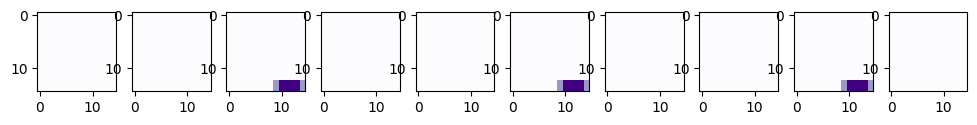

In [27]:
# create / reset the network
neurons = []

for h in range(column_height):
    neurons.append([])
    for x in range(field_width):
        for y in range(field_height):
            neuron = NeuronWithThreshold(
                (x, y, h),
                field_height=field_height,
                field_width=field_width,
                column_height=column_height,
                column_width=column_width,
                n_dendrites=n_dendrites,
                n_synapses=n_synapses,
                threshold=0.2
            )
            neurons[h].append(neuron)

# train
# for k in range(K):
#     input_data = [ input_saccades[k] ]
    
#     for h in range(column_height):
#         # forward
#         y_total = torch.zeros(column_height, field_width, field_height)

#         for n in neurons[h]:
#             xx = input_data[h][n.pos[0], n.pos[1]]
#             y = n.forward(xx)
#             for i in range(y.shape[1]):
#                 p = n.i_to_neuron_pos(i)
#                 if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
#                     continue
#                 y_total[p[2], p[0], p[1]] += y[0,i]
        
#         input_data.append(y_total[h])
        
#         # update
#         for n in neurons[h]:
#             xx = input_data[h][n.pos[0], n.pos[1]]
#             yy = torch.zeros(1, n_column_neurons)
#             for i in range(n_column_neurons):
#                 p = n.i_to_neuron_pos(i)
#                 if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
#                     continue
#                 yy[0, i] = y_total[p[2], p[0], p[1]]

#             n.update_weights(xx, yy)

# test
test_data = input_saccades[0]

y_total = torch.zeros(column_height, field_width, field_height)
y_copies = []
n_spike_train = 10

for t in range(n_spike_train):
    for n in neurons[0]:
        xx = test_data[n.pos[0], n.pos[1]]
        y = n.forward(xx)
        for i in range(y.shape[1]):
            p = n.i_to_neuron_pos(i)
            if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                continue
            y_total[p[2], p[0], p[1]] += y[0,i]
    y_copies.append(y_total.clone().detach())
    if y_total.sum() > 0.0:
        # reset values
        y_total = torch.zeros(column_height, field_width, field_height)
        for n in neurons[0]:
            n.reset()

# plt.figure(figsize=(4, 4))
# x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# # x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
# plt.colorbar(x_mat)
# plt.title("Activation on layer 3")
# plt.tight_layout()
# plt.show()


fig, axs = plt.subplots(1, n_spike_train, figsize=(12, 6))
for i in range(1):
    for j in range(n_spike_train):
        axs[j].imshow(torch.mean(y_copies[j], dim=0), cmap=cm.Purples)
        # axs[j].imshow(y_copies[j][0], cmap=cm.Purples)

# plt.tight_layout()
plt.show()

## Active inference - update weights

This will be unlike any regular training where initial random weights can be negative and positive.

We will utilize small initial values and every neuron will have a big threshold.

In [53]:
# create / reset the network
neurons = []

for h in range(column_height):
    neurons.append([])
    for x in range(field_width):
        for y in range(field_height):
            neuron = NeuronWithThreshold(
                (x, y, h),
                field_height=field_height,
                field_width=field_width,
                column_height=column_height,
                column_width=column_width,
                n_dendrites=n_dendrites,
                n_synapses=n_synapses,
                threshold=0.2
            )
            neurons[h].append(neuron)


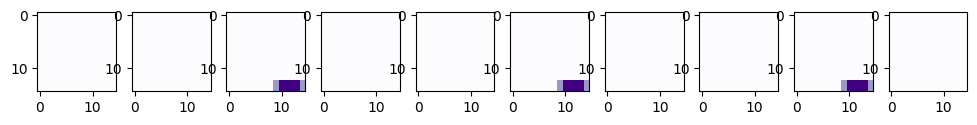

In [54]:
test_data = input_saccades[0]

y_total = torch.zeros(column_height, field_width, field_height)
y_copies = []
n_spike_train = 10

for t in range(n_spike_train):
    for n in neurons[0]:
        xx = test_data[n.pos[0], n.pos[1]]
        y = n.forward(xx)
        for i in range(y.shape[1]):
            p = n.i_to_neuron_pos(i)
            if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                continue
            y_total[p[2], p[0], p[1]] += y[0,i]
    y_copies.append(y_total.clone().detach())
    if y_total.sum() > 0.0:
        # reset values
        y_total = torch.zeros(column_height, field_width, field_height)
        for n in neurons[0]:
            n.reset()

# plt.figure(figsize=(4, 4))
# x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# # x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
# plt.colorbar(x_mat)
# plt.title("Activation on layer 3")
# plt.tight_layout()
# plt.show()


fig, axs = plt.subplots(1, n_spike_train, figsize=(12, 6))
for i in range(1):
    for j in range(n_spike_train):
        axs[j].imshow(torch.mean(y_copies[j], dim=0), cmap=cm.Purples)
        # axs[j].imshow(y_copies[j][0], cmap=cm.Purples)

# plt.tight_layout()
plt.show()

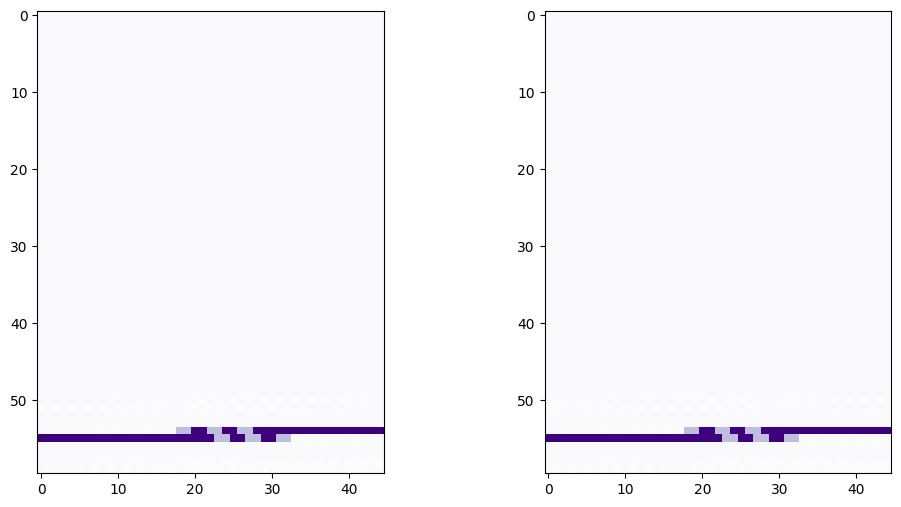

In [70]:
input_data = [ input_saccades[0] ]

y_copies = []    
y_total = torch.zeros(column_height, field_width, field_height)
h = 0

# forward
for n in neurons[h]:
    xx = input_data[h][n.pos[0], n.pos[1]]
    y = n.forward(xx)
    for i in range(y.shape[1]):
        p = n.i_to_neuron_pos(i)
        if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
            continue
        y_total[p[2], p[0], p[1]] += y[0,i]

# Combine small tensors into a larger tensor grid
weights = torch.cat([n.weight for n in neurons[h]], dim=0)
plot_tensor = weights.view(-1, field_height * column_height)
y_copies.append(plot_tensor.clone().detach())

if y_total.sum() > 0.0:

    # update
    print("--update--")
    for n in neurons[h]:
        xx = input_data[h][n.pos[0], n.pos[1]]
        yy = torch.zeros(1, n_column_neurons)
        for i in range(n_column_neurons):
            p = n.i_to_neuron_pos(i)
            if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                continue
            yy[0, i] = y_total[p[2], p[0], p[1]]

        n.update_weights(xx, yy)


    # reset values
    y_total = torch.zeros(column_height, field_width, field_height)
    for n in neurons[0]:
        n.reset()

weights = torch.cat([n.weight for n in neurons[h]], dim=0)
plot_tensor = weights.view(-1, field_height * column_height)
y_copies.append(plot_tensor.clone().detach())
# y_copies.append(y_total.clone().detach())

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(1):
    for j in range(2):
        axs[j].imshow(y_copies[j], cmap=cm.Purples)

# plt.tight_layout()
plt.show()

In [73]:
neurons[0][0].weight

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000]])

In [83]:
neurons[0][15*15-4].weight

tensor([[0.0997, 0.1000, 0.0997, 0.1000, 0.0997, 0.1000, 0.0997, 0.1000, 0.0997,
         0.1000, 0.0997, 0.1000]])

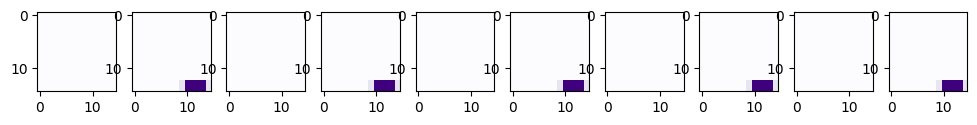

In [68]:
test_data = input_saccades[0]

y_total = torch.zeros(column_height, field_width, field_height)
y_copies = []
n_spike_train = 10

for t in range(n_spike_train):
    for n in neurons[0]:
        xx = test_data[n.pos[0], n.pos[1]]
        y = n.forward(xx)
        for i in range(y.shape[1]):
            p = n.i_to_neuron_pos(i)
            if p[0] < 0 or p[0] >= field_width or p[1] < 0 or p[1] >= field_height:
                continue
            y_total[p[2], p[0], p[1]] += y[0,i]
    y_copies.append(y_total.clone().detach())
    if y_total.sum() > 0.0:
        # reset values
        y_total = torch.zeros(column_height, field_width, field_height)
        for n in neurons[0]:
            n.reset()

# plt.figure(figsize=(4, 4))
# x_mat = plt.imshow(torch.mean(y_total, dim=0), cmap=cm.coolwarm)
# # x_mat = plt.imshow(y_total[2,:,:], cmap=cm.coolwarm)
# plt.colorbar(x_mat)
# plt.title("Activation on layer 3")
# plt.tight_layout()
# plt.show()


fig, axs = plt.subplots(1, n_spike_train, figsize=(12, 6))
for i in range(1):
    for j in range(n_spike_train):
        axs[j].imshow(torch.mean(y_copies[j], dim=0), cmap=cm.Purples)
        # axs[j].imshow(y_copies[j][0], cmap=cm.Purples)

# plt.tight_layout()
plt.show()

In [69]:
y_copies[1][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

## Real SOM

In [ ]:
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.n_neurons = self.m * self.n
        # gain coefficient
        self.alpha = 0.3
        # correction
        self.sigma = max(m, n) / 2.0
        
        if alpha is not None:
            self.alpha = float(alpha)
        if sigma is not None:
            self.sigma = float(sigma)

        self.weights = torch.randn(self.n_neurons, dim)
        self.locations = torch.tensor(np.array(list(self.make_grid_locations_iter(m, n))), dtype=torch.int32)
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def make_grid_locations_iter(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(self.n_neurons)],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, learning_rate_op):
        dists = self.pdist(x, self.weights) # compare X with every column in W. columns is a batch dimension
        bmu_index = dists.min(0).indices # find the minimum distance
        bmu_loc = self.locations[bmu_index,:]
        
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        diff = self.locations - bmu_loc # .unsqueeze(0).repeat(self.n_neurons, 1) - don't need to copy because broadcasting will do it (ref: https://numpy.org/doc/stable/user/basics.broadcasting.html)
        bmu_distance_squares = torch.sum(torch.pow(diff.float(), 2), 1) # array where for every neuron i: x_i ^2 + y_i ^2 -> d_i
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2))) # e^{ -(d_i / sigma^2) }
        gain_coefficient = alpha_op * neighbourhood_func
        learning_rate_multiplier = gain_coefficient.repeat(self.dim, 1).T # copy to every dimension
        delta = torch.mul(learning_rate_multiplier, x - self.weights) # (x - self.weights) - uses broadcasting too

        self.weights += delta
    
    def forward_no_training(self, x):
        # find a location where the distance between x and m_i is the minimum 
        min_index = torch.linalg.vector_norm(x - self.weights, ord=2, dim=1).min(0).indices
        return self.locations[min_index]

In [ ]:
batch_size = 100
n_iter = 5
som_dim = N * N
som = SOM(N, N, som_dim)

for iter_no in range(n_iter):
    data = create_displaced_tensors(input, K=batch_size, receptive_field_size=(N, N))
    # data dimension is 225 (15x15)
    for i in range(len(data)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(data[i], learning_rate_op)